In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#/content/drive/MyDrive/Colab Notebooks/Comets_Bodybuilding

Mounted at /content/drive


## Move photos zip file to Colab directory and unzip

For production, we need to copy all selected photos to a separate folder in Google Drive, then zip them together and proceed as below.

In [3]:
!pwd

/content


In [4]:
# Copy the .zip folder to Google Colab
#!cp drive/MyDrive/Bodybuilding_competition/photos_selected/selected_photos.zip /content/selected_photos.zip

# Luke's cp:
!cp "/content/drive/MyDrive/Colab Notebooks/Comets_Bodybuilding/Bodybuilding_competition/photos_selected/selected_photos.zip" "/content/selected_photos.zip"

# David's cp:
#!cp "/content/drive/MyDrive/Bodybuilding_competition/photos_selected/selected_photos.zip" "/content/selected_photos.zip"

In [5]:
# Make the destination folder
!mkdir /content/selected_photos

In [6]:
# Unzip to directory of same name as .zip folder
#-n never overwrite existing files. If a file already exists, skip the extraction of that file without prompting.
!unzip -n /content/selected_photos.zip -d /content/selected_photos

Archive:  /content/selected_photos.zip
  inflating: /content/selected_photos/photos_selected/cpa_CPA PEI Physique Championships_2024_MEN_S PHYSIQUE_open_Phil Crabbe_000.jpg  
  inflating: /content/selected_photos/photos_selected/cpa_CPA PEI Physique Championships_2024_MEN_S PHYSIQUE_open_Prasanna Tiwari_002.jpg  
  inflating: /content/selected_photos/photos_selected/npcw_NPC Worldwide Victoria State Championships_2024_MEN_S PHYSIQUE_open_Omar Al-Dahiree_054.jpg  
  inflating: /content/selected_photos/photos_selected/cpa_CPA PEI Physique Championships_2024_MEN_S PHYSIQUE_open_Anthony Winston I I I_003.jpg  
  inflating: /content/selected_photos/photos_selected/npcw_NPC Worldwide Victoria State Championships_2024_MEN_S PHYSIQUE_open_Aaron Smith_035.jpg  
  inflating: /content/selected_photos/photos_selected/npcw_NPC Worldwide Victoria State Championships_2024_MEN_S PHYSIQUE_open_George Vongsykeo_003.jpg  
  inflating: /content/selected_photos/photos_selected/npcw_NPC Worldwide Victoria S

## Get the data frame from the pickle file on Google Drive

For production, we need to stack all of the pickles with selected photos together into one.

In [7]:
torch.cuda.is_available()
device = torch.device("cuda")
print(device)

cuda


In [8]:
# Luke's path:
df_train_path = '/content/drive/MyDrive/Colab Notebooks/Comets_Bodybuilding/Bodybuilding_competition/Pickles/df_train.pkl'
# David's path:
#df_train_path = '/content/drive/MyDrive/Bodybuilding_competition/Pickles/df_train.pkl'

df_train = pd.read_pickle(df_train_path)

# Luke's path:
df_val_path = '/content/drive/MyDrive/Colab Notebooks/Comets_Bodybuilding/Bodybuilding_competition/Pickles/df_val.pkl'
# David's path:
#df_val_path = '/content/drive/MyDrive/Bodybuilding_competition/Pickles/df_val.pkl'
df_val = pd.read_pickle(df_val_path)

In [9]:
df_train.head()

,organization,competition_name,year,division,class,person_name,rank,photo_filenames
0,ifbb,IFBB Border States Pro,2024,MEN'S PHYSIQUE,open,Jason Huynh,1,[ifbb_IFBB Border States Pro_2024_MEN'S PHYSIQ...
1,ifbb,IFBB Border States Pro,2024,MEN'S PHYSIQUE,open,Rafael Oliveira,2,[ifbb_IFBB Border States Pro_2024_MEN'S PHYSIQ...
2,ifbb,IFBB Border States Pro,2024,MEN'S PHYSIQUE,open,Zahid Sahak,3,[ifbb_IFBB Border States Pro_2024_MEN'S PHYSIQ...
3,ifbb,IFBB Border States Pro,2024,MEN'S PHYSIQUE,open,Joshua Guidry,4,[ifbb_IFBB Border States Pro_2024_MEN'S PHYSIQ...
4,ifbb,IFBB Border States Pro,2024,MEN'S PHYSIQUE,open,Reuben Glass,5,[ifbb_IFBB Border States Pro_2024_MEN'S PHYSIQ...


In [10]:
df_val.head()

,organization,competition_name,year,division,class,person_name,rank,photo_filenames
0,npc,NPC Idaho Cup Natural,2024,MEN'S PHYSIQUE,open,Bobby Hewey,1,[npc_NPC Idaho Cup Natural_2024_MEN'S PHYSIQUE...
1,npc,NPC Idaho Cup Natural,2024,MEN'S PHYSIQUE,open,Davis Rudkin,2,[npc_NPC Idaho Cup Natural_2024_MEN'S PHYSIQUE...
2,npc,NPC Idaho Cup Natural,2024,MEN'S PHYSIQUE,open,Henry Hill,3,[npc_NPC Idaho Cup Natural_2024_MEN'S PHYSIQUE...
3,npc,NPC Idaho Cup Natural,2024,MEN'S PHYSIQUE,open,Aaron Valdez,4,[npc_NPC Idaho Cup Natural_2024_MEN'S PHYSIQUE...
4,npc,NPC Idaho Cup Natural,2024,MEN'S PHYSIQUE,open,Greg Marsh,5,[npc_NPC Idaho Cup Natural_2024_MEN'S PHYSIQUE...


In [11]:
# Get numpy arrays of contest names, placing, and img names for each contestant for the training set
competitor_name_train_a = df_train['person_name'].to_numpy()
placing_train_a = df_train['rank'].to_numpy()
img_names_train_a = df_train['photo_filenames'].to_numpy()
competition_name_train_a = df_train['competition_name'].to_numpy()

# Get numpy arrays of contest names, placing, and img names for each contestant for the validation set
competitor_name_val_a = df_val['person_name'].to_numpy()
placing_val_a = df_val['rank'].to_numpy()
img_names_val_a = df_val['photo_filenames'].to_numpy()
competition_name_val_a = df_val['competition_name'].to_numpy()

In [12]:
img_dir_path = '/content/selected_photos/photos_selected/'

In [13]:
print(img_names_train_a[0][0])
print(img_names_val_a[0][0])

ifbb_IFBB Border States Pro_2024_MEN'S PHYSIQUE_open_Jason Huynh_053.jpg
npc_NPC Idaho Cup Natural_2024_MEN'S PHYSIQUE_open_Bobby Hewey_021.jpg


## Get an image

In [14]:
# load the image
img1_path = img_dir_path + img_names_train_a[0][0]
img1_path = img1_path.replace("'", "_")
print(img1_path)
img1 = Image.open(img1_path)

/content/selected_photos/photos_selected/ifbb_IFBB Border States Pro_2024_MEN_S PHYSIQUE_open_Jason Huynh_053.jpg


In [15]:
# Set resize dimensions
rs_dim = 128 #128

In [16]:
# Write transform for images to resize and convert to tensor - trying resizing to 128x128
data_transform = transforms.Compose([
    # Resize the images to 128x128
    #transforms.Resize(size=(64, 64)),
    #transforms.Resize(size=(128, 128)),
    #transforms.Resize(size=(256, 256)),
    transforms.Resize(size=(rs_dim, rs_dim)),

    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [17]:
# Convert image to tensor
img1_t = data_transform(img1)
img1_t.shape

torch.Size([3, 128, 128])

## Get another image

In [18]:
# Get image
img2_path = img_dir_path + img_names_val_a[1][1]
img2_path = img2_path.replace("'", "_")
img2 = Image.open(img2_path)

# Convert to tensor
img2_t = data_transform(img2)
img2_t.shape

torch.Size([3, 128, 128])

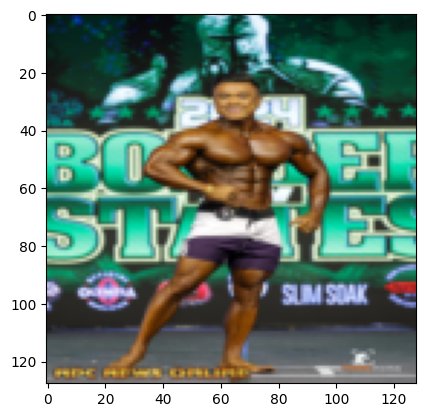

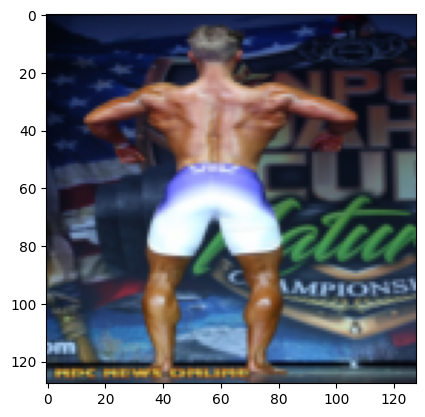

2


In [19]:
# Plot tensor 1
plt.imshow(img1_t.permute(1, 2, 0))
plt.show()

# Plot tensor 2
plt.imshow(img2_t.permute(1, 2, 0))
plt.show()

print(len(img_names_val_a[1]))

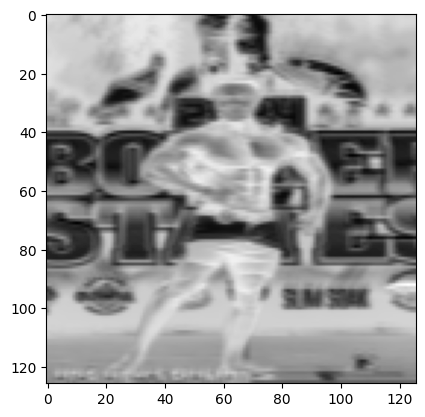

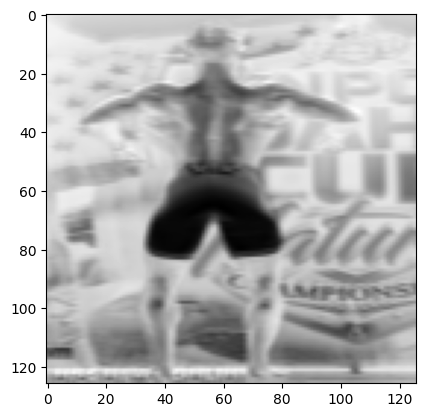

In [20]:
# Check what a convolution looks like

conv = nn.Conv2d(3, 16, kernel_size=3)

output1 = conv(img1_t.unsqueeze(0))
output2 = conv(img2_t.unsqueeze(0))

plt.imshow(output1[0, 0].detach(), cmap='gray')
plt.show()

plt.imshow(output2[0, 0].detach(), cmap='gray')
plt.show()

In [21]:
output1.shape

torch.Size([1, 16, 126, 126])

## Make an untrained network we can plug these images into

Let's say 0 output means img1 wins and 1 output means img2 wins

In [22]:
class TwoInputNet(nn.Module):
    def __init__(self):
        super(TwoInputNet, self).__init__()

        # Define layers for input 1
        self.input1_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),  # Consider using ReLU instead of Tanh
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # Increased channels
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Increased channels
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Define layers for input 2 - Same architecture as input 1
        self.input2_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Combine layers - Adjust input size based on output of CNNs
        self.combined_layers = nn.Sequential(
            nn.Linear(64 * (rs_dim // 8) * (rs_dim // 8) * 2, 256), # adjust the first dimension
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output between 0 and 1 for "second image wins" probability
        )

    def forward(self, input1, input2):
        # Process input 1
        x1 = self.input1_layers(input1)
        x1 = x1.view(x1.size(0), -1)  # Flatten for the linear layer

        # Process input 2
        x2 = self.input2_layers(input2)
        x2 = x2.view(x2.size(0), -1)  # Flatten for the linear layer

        # Concatenate outputs
        x = torch.cat((x1, x2), dim=1)

        # Pass through combined layers
        x = self.combined_layers(x)

        return x

## Create a custom Dataset subclass

What exactly is
```
paths_list: list[list[str]]
```
doing in the ```__init__``` function below?

In the line ```image_path = self.paths[index][0]``` what is the second index referencing? Is it the first and second competitors or the first and second images from one competitor?


In [23]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)

# 1. Subclass torch.utils.data.Dataset
class CustomDataset(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, paths_list: list[list[str]], labels: list[int], transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = paths_list
        # Get all labels of who won
        self.labels = labels
        # Setup transforms
        self.transform = transform

    # 4. Make function to load images
    def load_image0(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index][0]
        return Image.open(image_path)

    def load_image1(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index][1]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int):# -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img0 = self.load_image0(index)
        img1 = self.load_image1(index)
        label = self.labels[index]

        # Transform if necessary
        if self.transform:
            return self.transform(img0), self.transform(img1), label # return data, label (X0, X1, y)
        else:
            return img0, img1, label # return data, label (X0, X1, y)

## Use the subclass to create an actual dataset

Are the photos of the back of the bodybuilders ever loaded into the lists below? Are they ever included in our data set and NN, or are we just using the front photos?

In [24]:
# Dataset lists for training set
paths_list_train = []
labels_list_train = []

for i in range(len(competitor_name_train_a)):
  for j in range(len(competitor_name_train_a)):
    if (placing_train_a[i] != placing_train_a[j]) and (competition_name_train_a[i] == competition_name_train_a[j]):
      img_path_1 = img_dir_path + img_names_train_a[i][0]
      img_path_2 = img_dir_path + img_names_train_a[j][0]
      img_path_1 = img_path_1.replace("'", "_")
      img_path_2 = img_path_2.replace("'", "_")
      paths_list_train.append([img_path_1, img_path_2])
      if placing_train_a[i] > placing_train_a[j]:
        labels_list_train.append(0)
      else:
        labels_list_train.append(1)

# Dataset lists for validation set
paths_list_val = []
labels_list_val = []

for i in range(len(competitor_name_val_a)):
  for j in range(len(competitor_name_val_a)):
    if (placing_val_a[i] != placing_val_a[j]) and (competition_name_val_a[i] == competition_name_val_a[j]):
      img_path_1 = img_dir_path + img_names_val_a[i][0]
      img_path_2 = img_dir_path + img_names_val_a[j][0]
      img_path_1 = img_path_1.replace("'", "_")
      img_path_2 = img_path_2.replace("'", "_")
      paths_list_val.append([img_path_1, img_path_2])
      if placing_val_a[i] > placing_val_a[j]:
        labels_list_val.append(0)
      else:
        labels_list_val.append(1)

In [25]:
data_train = CustomDataset(paths_list_train, labels_list_train, data_transform)
print(f'len(data_train): {len(data_train)}')

data_val = CustomDataset(paths_list_val, labels_list_val, data_transform)
print(f'len(data_val): {len(data_val)}')

print(f'percent train: {len(data_train)/(len(data_train)+len(data_val))}')

len(data_train): 11776
len(data_val): 3236
percent train: 0.7844391153743672


In [26]:
print(data_train[0])
print(data_val[0])

(tensor([[[0.0235, 0.0196, 0.0196,  ..., 0.0039, 0.0000, 0.0039],
         [0.0275, 0.0235, 0.0157,  ..., 0.0078, 0.0078, 0.0118],
         [0.0275, 0.0275, 0.0196,  ..., 0.0118, 0.0157, 0.0078],
         ...,
         [0.4784, 0.4902, 0.4196,  ..., 0.6118, 0.6000, 0.5961],
         [0.5294, 0.5373, 0.4824,  ..., 0.4745, 0.4627, 0.4627],
         [0.4706, 0.4706, 0.4627,  ..., 0.4667, 0.4549, 0.4627]],

        [[0.0549, 0.0824, 0.0824,  ..., 0.1608, 0.1608, 0.1412],
         [0.0510, 0.0706, 0.0980,  ..., 0.1333, 0.1176, 0.1137],
         [0.0510, 0.0627, 0.0902,  ..., 0.1098, 0.1098, 0.1294],
         ...,
         [0.4824, 0.4902, 0.4039,  ..., 0.6118, 0.6039, 0.5961],
         [0.5333, 0.5412, 0.4784,  ..., 0.4706, 0.4588, 0.4588],
         [0.4627, 0.4667, 0.4549,  ..., 0.4549, 0.4510, 0.4588]],

        [[0.0627, 0.0784, 0.0784,  ..., 0.1176, 0.1137, 0.0980],
         [0.0588, 0.0706, 0.0824,  ..., 0.0980, 0.0863, 0.0863],
         [0.0588, 0.0667, 0.0824,  ..., 0.0863, 0.0824, 0

## Training

In [27]:
#Hyperparameters
n_workers = 108 #12 #108
batch_size = 256 #512
n_epochs = 20 #70
learning_rate = 1e-2
#Learning rate   | Result
#1e-2            | Flatline
#1e-4            | Flatline

In [28]:
print(torch.cuda.get_device_properties(0).multi_processor_count)

108


## Two additional models and a training loop that returns losses and accuracies for each epoch

In [29]:
data_train = CustomDataset(paths_list_train, labels_list_train, data_transform)
print(f'len(data_train): {len(data_train)}')

data_val = CustomDataset(paths_list_val, labels_list_val, data_transform)
print(f'len(data_val): {len(data_val)}')

data_train_short = CustomDataset(paths_list_train[:len(paths_list_train)//1], labels_list_train[:len(labels_list_train)//1], data_transform)
data_val_short = CustomDataset(paths_list_val[:len(paths_list_val)//1], labels_list_val[:len(labels_list_val)//1], data_transform)
print(f'len(data_train_short): {len(data_train_short)}')
print(f'len(data_val_short): {len(data_val_short)}')

len(data_train): 11776
len(data_val): 3236
len(data_train_short): 11776
len(data_val_short): 3236


In [30]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=n_workers)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True, num_workers=n_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 108 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [31]:
# Test network
class TwoInputNet_test(nn.Module):
    def __init__(self):
        super(TwoInputNet_test, self).__init__()

        # Define layers for input 1
        self.input1_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Define layers for input 2 - Same architecture as input 1
        self.input2_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Combine layers - Adjust input size based on output of CNNs
        self.combined_layers = nn.Sequential(
            nn.Linear(128 * (rs_dim // 16) * (rs_dim // 16) * 2, 256), # adjust the first dimension
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output between 0 and 1 for "second image wins" probability
        )

    def forward(self, input1, input2):
        # Process input 1
        x1 = self.input1_layers(input1)
        x1 = x1.view(x1.size(0), -1)  # Flatten for the linear layer

        # Process input 2
        x2 = self.input2_layers(input2)
        x2 = x2.view(x2.size(0), -1)  # Flatten for the linear layer

        # Concatenate outputs
        x = torch.cat((x1, x2), dim=1)

        # Pass through combined layers
        x = self.combined_layers(x)

        return x

In [32]:
import torchvision.models as models

class TwoInputNet_resnet(nn.Module):
    def __init__(self):
        super(TwoInputNet_resnet, self).__init__()

        # Load pre-trained ResNet50 models for both inputs
        self.resnet1 = models.resnet50(pretrained=True)
        self.resnet2 = models.resnet50(pretrained=True)

        # Remove the final fully connected layer from each ResNet50
        self.resnet1.fc = nn.Identity()
        self.resnet2.fc = nn.Identity()

        # Define the combined layers
        self.combined_layers = nn.Sequential(
            nn.Linear(2048 * 2, 256),  # Input size is 2048 from each ResNet50
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Pass inputs through ResNet50 models
        x1 = self.resnet1(input1)
        x2 = self.resnet2(input2)

        # Concatenate the outputs
        x = torch.cat((x1, x2), dim=1)

        # Pass through combined layers
        x = self.combined_layers(x)

        return x

In [33]:
# Define a training loop
def training_loop_test(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
  model.to(device)

  loss_train_list = []
  loss_val_list = []
  acc_train_list = []
  acc_val_list = []
  for epoch in range(1, n_epochs + 1):
    model.train() #Sets model to training mode (from Gemini)
    loss_train = 0.0
    loss_val = 0.0
    acc_train = 0.0
    acc_val = 0.0

    correct_train = 0
    total_train = 0
    # This loop calculates the training loss
    for img0, img1, labels in train_loader:
      img0 = img0.to(device)
      img1 = img1.to(device)
      outputs = model(img0, img1)
      # Squeeze the output to match the target shape
      outputs = outputs.squeeze(1)  # Remove the extra dimension (channel)

      # Cast outputs and labels to Float before calculating the loss
      outputs = outputs.float()
      labels = labels.float()
      labels = labels.to(device)

      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()

      # Calculate accuracy
      predicted = torch.round(outputs)
      total_train += labels.shape[0]
      correct_train += int((predicted == labels).sum())

    correct_val = 0
    total_val = 0
    model.eval() #Sets model to evaluation mode
    with torch.no_grad():
      # This loop calculates the validation loss
      # Note: We do not run the optimizer or backward functions for this loop
      for img0, img1, labels in val_loader:
        img0 = img0.to(device)
        img1 = img1.to(device)
        outputs = model(img0, img1)
        # Squeeze the output to match the target shape
        outputs = outputs.squeeze(1)  # Remove the extra dimension (channel)

        # Cast outputs and labels to Float before calculating the loss
        outputs = outputs.float()
        labels = labels.float()
        labels = labels.to(device)

        loss = loss_fn(outputs, labels)
        loss_val += loss.item()

        # Calculate accuracy
        predicted = torch.round(outputs)
        total_val += labels.shape[0]
        correct_val += int((predicted == labels).sum())

    loss_train_list.append(loss_train / len(train_loader))
    loss_val_list.append(loss_val / len(val_loader))
    acc_train_list.append(correct_train / total_train)
    acc_val_list.append(correct_val / total_val)

    if epoch == 1 or epoch % 1 == 0:
      print('{} Epoch {}, Training loss {}, Validation loss {}'.format(
        datetime.datetime.now(), epoch,
        loss_train / len(train_loader),
        loss_val / len(val_loader)))

      print('     Training acc {}, Validation acc {}'.format(
        correct_train / total_train,
        correct_val / total_val))

  return loss_train_list, loss_val_list, acc_train_list, acc_val_list

In [34]:
model_select = "base"
model = None
if model_select == "test":
  model = TwoInputNet_test()
elif model_select == "resnet":
  model = TwoInputNet_resnet()
else:
  model_select = "base"
  model = TwoInputNet()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCELoss()

In [35]:
import pickle
print('{} Starting training loop.'.format(datetime.datetime.now()))

train_losses, val_losses, train_accs, val_accs = training_loop_test(
  n_epochs = n_epochs,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = train_loader,
  val_loader = val_loader
)

current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'/content/drive/MyDrive/Colab Notebooks/Comets_Bodybuilding/Bodybuilding_competition/Pickles/trained_model_{model_select}_{current_datetime}.pkl'

#filename = f"trained_model_{model_select}_{current_datetime}.pkl"

with open(filename, 'wb') as f:
  pickle.dump(model,f)

2024-12-11 19:34:25.797162 Starting training loop.
2024-12-11 19:35:12.211259 Epoch 1, Training loss 0.6931252686873727, Validation loss 0.6932233709555405
     Training acc 0.5067934782608695, Validation acc 0.5
2024-12-11 19:35:57.457613 Epoch 2, Training loss 0.6929927649705306, Validation loss 0.6931960445183974
     Training acc 0.5174082880434783, Validation acc 0.4984548825710754
2024-12-11 19:36:43.822367 Epoch 3, Training loss 0.6928219186223071, Validation loss 0.6931746647908137
     Training acc 0.5232676630434783, Validation acc 0.4941285537700865
2024-12-11 19:37:29.352643 Epoch 4, Training loss 0.6926968603030496, Validation loss 0.6931678836162274
     Training acc 0.5172384510869565, Validation acc 0.5
2024-12-11 19:38:16.943980 Epoch 5, Training loss 0.6925886091978654, Validation loss 0.6931423453184274
     Training acc 0.5218240489130435, Validation acc 0.5033992583436341
2024-12-11 19:39:03.279246 Epoch 6, Training loss 0.6924995559713115, Validation loss 0.693135

In [36]:
print(len(train_losses), train_losses)
print(len(val_losses), val_losses)
print(len(train_accs), train_accs)
print(len(val_accs), val_accs)

20 [0.6931252686873727, 0.6929927649705306, 0.6928219186223071, 0.6926968603030496, 0.6925886091978654, 0.6924995559713115, 0.6923356341279071, 0.6922824486442234, 0.6920198733391969, 0.6919781254685443, 0.6918368546859078, 0.6915651378424271, 0.6914689553820569, 0.691316545009613, 0.6912206152211064, 0.6910770418851272, 0.6908161303271418, 0.6907539108525151, 0.6904608542504518, 0.6902785223463307]
20 [0.6932233709555405, 0.6931960445183974, 0.6931746647908137, 0.6931678836162274, 0.6931423453184274, 0.6931358942618737, 0.6931751003632178, 0.6931187877288232, 0.6931695846410898, 0.6931019104444064, 0.6931024331312913, 0.6931439133790823, 0.6931092876654404, 0.6931096773881179, 0.6930179687646719, 0.693008725459759, 0.693127324947944, 0.6929754660679743, 0.6931425929069519, 0.6930084182665899]
20 [0.5067934782608695, 0.5174082880434783, 0.5232676630434783, 0.5172384510869565, 0.5218240489130435, 0.5314198369565217, 0.5362601902173914, 0.5479789402173914, 0.5481487771739131, 0.537873641

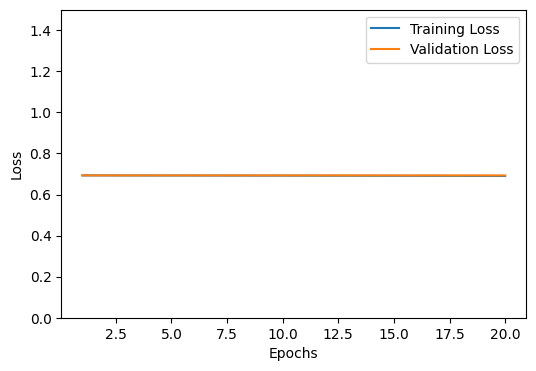

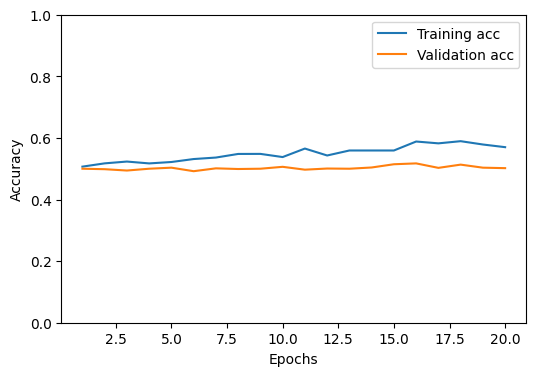

In [37]:
plt.figure(figsize=(6, 4))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1.5)
plt.legend()
plt.show()


plt.figure(figsize=(6, 4))
epochs = range(1, n_epochs + 1)
plt.plot(epochs, train_accs, label='Training acc')
plt.plot(epochs, val_accs, label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()